# INDEX
* [Imports and functions](#Imports-and-functions)
* [Configuration](#Configuration)
* [Prepare dataset](#Prepare-dataset)
* [Build model](#Build-model)
    * [Model inputs](#Model-inputs)
    * [Model output](#Model-output)
    * [Model](#Model)
* [Train model](#Train-model)
    * [Save model and resources](#Save-model-and-resources)
    * [Training stats](#Training-stats)
* [Test model](#Test-model)
    * [Predict](#Predict)
    * [Translate predictions](#Translate-predictions)

# Imports and functions

In [1]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [2]:
from collections import Counter
import dacite
import itertools
import json
import pathlib
import shutil

import pandas as pd

import tensorflow as tf
from tensorflow.keras import callbacks, layers
from tensorflow.python.ops import summary_ops_v2
import tensorflow_datasets as tfds

#import settings

from category_classification.config import Config

# TODO
# from category_classification.models import (
#     to_serving_model,
# )

# TODO
# from utils.io import (
#     copy_category_taxonomy,
#     save_category_vocabulary,
#     save_config,
#     save_json,
# )

# TODO
# from utils.metrics import evaluation_report


# TODO: move to lib
class TBCallback(callbacks.TensorBoard):
    """Get around a bug where you cannot use the TensorBoard callback with the StringLookup layers
    - https://github.com/tensorflow/tensorboard/issues/4530#issuecomment-783318292"""

    def _log_weights(self, epoch):
        with self._train_writer.as_default():
            with summary_ops_v2.always_record_summaries():
                for layer in self.model.layers:
                    for weight in layer.weights:
                        if hasattr(weight, "name"):
                            weight_name = weight.name.replace(":", "_")
                            summary_ops_v2.histogram(weight_name, weight, step=epoch)
                            if self.write_images:
                                self._log_weight_as_image(weight, weight_name, epoch)
                self._train_writer.flush()


                
# TODO: move to lib
def batch_flatten(ds: tf.data.Dataset, batch_size: int):
    """
    Flatten unbatched rank-2 string tensors into batches of rank-1 tensors.
        
    Parameters
    ----------
    ds : tf.data.Dataset
        Single-feature dataset.
    
    batch_size : int
        Batch size for the returned dataset.
    
    Returns
    -------
    tf.data.Dataset
        Flattened, batched dataset.
        
    Examples
    --------
    t = [Tensor(['foo', 'bar']), Tensor(['baz']), Tensor(['qux'])]
    -> [['foo', 'bar', 'baz'], ['qux']]

    """

    return (
        ds
        .apply(tf.data.experimental.dense_to_ragged_batch(batch_size))
        .map(lambda x: x.merge_dims(0, 1))
    )


def get_vocabulary(ds: tf.data.Dataset, min_freq: int = 1):
    """
    Get the feature vocabulary.
    
    Parameters
    ----------
    ds : tf.data.Dataset
        Single-feature dataset.
    
    min_freq : int
        Minimum token frequency to be included in the vocabulary.
        Tokens strictly below `min_freq` won't be listed.
    
    Returns
    -------
    list
        List of tokens in the vocabulary
    """
    counter = Counter()
    for batch in ds:
        counter.update(batch.numpy())
    return [
        x[0].decode()
        for x in itertools.takewhile(lambda x: x[1] >= min_freq, counter.most_common())
    ]


def get_feature(ds: tf.data.Dataset, feature_name: str):
    """
    Parameters
    ----------
    ds : tf.data.Dataset
        Dataset. Nested features are not supported.
    
    feature_name : str
        Name of the feature to select.

    Returns
    -------
    tf.data.Dataset
        Dataset containing only the feature `feature_name`.
    """
    return ds.map(lambda x: x[feature_name])

2022-05-16 18:43:49.304767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 18:43:49.304787: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gabriel/.pyenv/versions/3.8.13/envs/venv-off-tf28/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [3]:
with open('../config.json') as json_file:
    json_config = json.load(json_file)
    config = dacite.from_dict(Config, json_config)

model_config = config.model_config
train_config = config.train_config

CACHE_DIR = pathlib.Path('../cache')
CACHE_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = pathlib.Path('../models')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

PREPROC_BATCH_SIZE = 10_000  # some large value

TRAIN_SPLIT = 'train'
VAL_SPLIT = 'val'
TEST_SPLIT = 'test'

# ONLY FOR DEMO PURPOSE, so training goes faster
#TRAIN_SPLIT = 'train[:10%]'
#VAL_SPLIT = 'val[:10%]'
#train_config.epochs = 2

# Prepare dataset

Run this once to fetch, build and cache the dataset.
Further runs will be no-ops, unless you force operations (see TFDS doc).

Once this is done, `tdfs.load('off_category', ...)` to access the dataset.

In [4]:
import datasets.off_category

builder = tfds.builder('off_category')
builder.download_and_prepare()

# Or run via command line (if `tfds` is in the path):
# !cd ../datasets && tfds build off_category

# Build model

In [5]:
tf.random.set_seed(42)

## Model inputs

In [6]:
# we use dicts so rerunning individual model cells is idempotent
inputs = {}
input_graphs = {}

In [7]:
ds = tfds.load('off_category', split=TRAIN_SPLIT)

2022-05-16 18:43:50.627701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-16 18:43:50.627723: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-16 18:43:50.627750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alba): /proc/driver/nvidia/version does not exist
2022-05-16 18:43:50.627929: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
%%time

feature_name = 'product_name'

product_name_input = tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name)

product_name_vectorizer = layers.TextVectorization(
    split = 'whitespace',
    max_tokens = model_config.product_name_max_tokens,
    output_sequence_length = model_config.product_name_max_length)

product_name_vectorizer.adapt(
    get_feature(ds, feature_name).batch(PREPROC_BATCH_SIZE))

x = product_name_vectorizer(product_name_input)

x = layers.Embedding(
    input_dim = product_name_vectorizer.vocabulary_size(),
    output_dim = model_config.product_name_embedding_size,
    mask_zero = False)(x)

product_name_graph = layers.Bidirectional(layers.LSTM(
    units = model_config.product_name_lstm_units,
    recurrent_dropout = model_config.product_name_lstm_recurrent_dropout,
    dropout = model_config.product_name_lstm_dropout))(x)

inputs[feature_name] = product_name_input
input_graphs[feature_name] = product_name_graph

# expected: 93000
print(len(product_name_vectorizer.get_vocabulary()))

93000
CPU times: user 29 s, sys: 14.1 s, total: 43.1 s
Wall time: 8 s


In [9]:
%%time

feature_name = 'ingredients_tags'

ingredients_input = tf.keras.Input(shape=(None,), dtype=tf.string, name=feature_name)

ingredients_vocab = get_vocabulary(
    batch_flatten(get_feature(ds, feature_name), batch_size=PREPROC_BATCH_SIZE),
    min_freq = model_config.ingredient_min_count)

ingredients_graph = layers.StringLookup(
    vocabulary = ingredients_vocab,
    output_mode = 'multi_hot')(ingredients_input)

inputs[feature_name] = ingredients_input
input_graphs[feature_name] = ingredients_graph

# expected: 4223
print(len(ingredients_vocab))  # 4222 vs 4223 -> no b'' because no padded_batch

4222
CPU times: user 58.7 s, sys: 29.1 s, total: 1min 27s
Wall time: 14.1 s


## Model output

In [10]:
%%time

labels = 'categories_tags'

categories_vocab = get_vocabulary(
    batch_flatten(get_feature(ds, labels), batch_size=PREPROC_BATCH_SIZE),
    min_freq = model_config.category_min_count)

# StringLookup(output_mode='multi_hot') mode requires num_oov_indices >= 1.
# We don't want OOVs in the categories_tags output layer, since it wouldn't make
# sense to predict OOV. So we'll drop the OOV in _transform below.
# Be careful when using StringLookup methods, some of them will return values
# based on a vocabulary with OOV (e.g. vocabulary_size()). Keep this in mind when
# mapping predictions back to the original vocabulary.
categories_multihot = layers.StringLookup(
    vocabulary = categories_vocab,
    output_mode = 'multi_hot',
    num_oov_indices = 1)  

def categories_encode(ds: tf.data.Dataset):
    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _transform(x, y):
        y = categories_multihot(y)
        y = y[1:]  # drop OOV
        return (x, y)

    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _not_empty(x, y):
        return tf.math.reduce_max(y, 0) > 0

    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
        .filter(_not_empty)
    )

# expected: 3969
print(len(categories_vocab))

3969
CPU times: user 57.1 s, sys: 28.8 s, total: 1min 25s
Wall time: 14.2 s


## Model

In [11]:
# ensure final order is independent of cell execution/insertion order
features = sorted(inputs.keys())

x = layers.Concatenate()([input_graphs[k] for k in features])
x = layers.Dropout(model_config.hidden_dropout)(x)
x = layers.Dense(model_config.hidden_dim)(x)
x = layers.Dropout(model_config.hidden_dropout)(x)
x = layers.Activation('relu')(x)
output = layers.Dense(len(categories_vocab), activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs[k] for k in features], outputs=[output])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=train_config.lr),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=train_config.label_smoothing),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

In [12]:
model.summary()

# Model: "model"
# __________________________________________________________________________________________________
#  Layer (type)                   Output Shape         Param #     Connected to                     
# ==================================================================================================
#  product_name (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
#  text_vectorization (TextVector  (None, 30)          0           ['product_name[0][0]']           
#  ization)                                                                                         
                                                                                                  
#  ingredients_tags (InputLayer)  [(None, None)]       0           []                               
                                                                                                  
#  embedding (Embedding)          (None, 30, 64)       5952000     ['text_vectorization[0][0]']     
                                                                                                  
#  string_lookup_1 (StringLookup)  (None, 4223)        0           ['ingredients_tags[0][0]']       
                                                                                                  
#  bidirectional (Bidirectional)  (None, 128)          66048       ['embedding[0][0]']              
                                                                                                  
#  concatenate (Concatenate)      (None, 4351)         0           ['string_lookup_1[0][0]',        
#                                                                   'bidirectional[0][0]']          
                                                                                                  
#  dropout (Dropout)              (None, 4351)         0           ['concatenate[0][0]']            
                                                                                                  
#  dense (Dense)                  (None, 64)           278528      ['dropout[0][0]']                
                                                                                                  
#  dropout_1 (Dropout)            (None, 64)           0           ['dense[0][0]']                  
                                                                                                  
#  activation (Activation)        (None, 64)           0           ['dropout_1[0][0]']              
                                                                                                  
#  dense_1 (Dense)                (None, 3969)         257985      ['activation[0][0]']             
                                                                                                  
# ==================================================================================================
# Total params: 6,554,561
# Trainable params: 6,554,561
# Non-trainable params: 0

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product_name (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 30)          0           ['product_name[0][0]']           
 ization)                                                                                         
                                                                                                  
 ingredients_tags (InputLayer)  [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       5952000     ['text_vectorization[0][0]'] 

# Train model

In [13]:
%%time

# for now, clear cache on each call to fit(), to be safe
shutil.rmtree(CACHE_DIR, ignore_errors=True)
CACHE_DIR.mkdir()

# FIXME: clean OUTPUT_DIR?

print(f"Cache directory: {CACHE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

# FIXME: drop unused features (cause slower training?)

ds_train = (
    tfds.load('off_category', split=TRAIN_SPLIT, as_supervised=True)
    .apply(categories_encode)
    .padded_batch(train_config.batch_size)  # TODO: replace with ragged_batch?
    .cache(str(CACHE_DIR / 'train'))
)

ds_val = (
    tfds.load('off_category', split=VAL_SPLIT, as_supervised=True)
    .apply(categories_encode)
    .padded_batch(train_config.batch_size)
    .cache(str(CACHE_DIR / 'val'))
)

history = model.fit(
    ds_train,
    epochs = train_config.epochs,
    validation_data = ds_val,
    callbacks = [
        callbacks.TerminateOnNaN(),
        callbacks.ModelCheckpoint(
            filepath = str(OUTPUT_DIR / "weights.{epoch:02d}-{val_loss:.4f}"),
            monitor = 'val_loss',
            save_best_only = True,
            save_format = 'tf',
        ),
        callbacks.EarlyStopping(monitor='val_loss', patience=4),
        callbacks.CSVLogger(str(OUTPUT_DIR / 'training.log')),
        callbacks.History()
    ]
)

# Epoch 1/50
# 5465/5465 [==============================] - 451s 82ms/step - loss: 0.0082 - binary_accuracy: 0.9985 - precision: 0.2248 - recall: 0.0864 - val_loss: 0.0041 - val_binary_accuracy: 0.9990 - val_precision: 0.8444 - val_recall: 0.2421
# Epoch 18/50
# 5465/5465 [==============================] - 390s 71ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8880 - recall: 0.7968 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8886 - val_recall: 0.7911
# Training ended
# CPU times: user 10h 56min 3s, sys: 49min 56s, total: 11h 45min 59s
# Wall time: 2h 3min 54s

Cache directory: ../cache
Output directory: ../models
Epoch 1/50


2022-05-16 18:44:29.333694: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/home/gabriel/.pyenv/versions/3.8.13/envs/venv-off-tf28/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['code'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


   5465/Unknown - 435s 79ms/step - loss: 0.0081 - binary_accuracy: 0.9985 - precision: 0.2210 - recall: 0.0836

2022-05-16 18:51:44.633674: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-16 18:52:00.288243: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-16 18:52:02.365017: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so con

INFO:tensorflow:Assets written to: ../models/weights.01-0.0041/assets


INFO:tensorflow:Assets written to: ../models/weights.01-0.0041/assets


5465/5465 [==============================] - 456s 83ms/step - loss: 0.0081 - binary_accuracy: 0.9985 - precision: 0.2210 - recall: 0.0836 - val_loss: 0.0041 - val_binary_accuracy: 0.9990 - val_precision: 0.8468 - val_recall: 0.2567
Epoch 2/50


2022-05-16 18:52:05.384785: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5465/5465 [==============================] - ETA: 0s - loss: 0.0033 - binary_accuracy: 0.9991 - precision: 0.8153 - recall: 0.4081INFO:tensorflow:Assets written to: ../models/weights.02-0.0023/assets


INFO:tensorflow:Assets written to: ../models/weights.02-0.0023/assets


5465/5465 [==============================] - 414s 76ms/step - loss: 0.0033 - binary_accuracy: 0.9991 - precision: 0.8153 - recall: 0.4081 - val_loss: 0.0023 - val_binary_accuracy: 0.9993 - val_precision: 0.8819 - val_recall: 0.5518
Epoch 3/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8452 - recall: 0.5910INFO:tensorflow:Assets written to: ../models/weights.03-0.0018/assets


INFO:tensorflow:Assets written to: ../models/weights.03-0.0018/assets


5465/5465 [==============================] - 398s 73ms/step - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8452 - recall: 0.5910 - val_loss: 0.0018 - val_binary_accuracy: 0.9995 - val_precision: 0.8897 - val_recall: 0.6672
Epoch 4/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8574 - recall: 0.6627INFO:tensorflow:Assets written to: ../models/weights.04-0.0016/assets


INFO:tensorflow:Assets written to: ../models/weights.04-0.0016/assets


5465/5465 [==============================] - 387s 71ms/step - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8574 - recall: 0.6627 - val_loss: 0.0016 - val_binary_accuracy: 0.9995 - val_precision: 0.8899 - val_recall: 0.7115
Epoch 5/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8647 - recall: 0.6978INFO:tensorflow:Assets written to: ../models/weights.05-0.0015/assets


INFO:tensorflow:Assets written to: ../models/weights.05-0.0015/assets


5465/5465 [==============================] - 383s 70ms/step - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8647 - recall: 0.6978 - val_loss: 0.0015 - val_binary_accuracy: 0.9996 - val_precision: 0.8887 - val_recall: 0.7353
Epoch 6/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8696 - recall: 0.7205INFO:tensorflow:Assets written to: ../models/weights.06-0.0015/assets


INFO:tensorflow:Assets written to: ../models/weights.06-0.0015/assets


5465/5465 [==============================] - 378s 69ms/step - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8696 - recall: 0.7205 - val_loss: 0.0015 - val_binary_accuracy: 0.9996 - val_precision: 0.8919 - val_recall: 0.7478
Epoch 7/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8733 - recall: 0.7362INFO:tensorflow:Assets written to: ../models/weights.07-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.07-0.0014/assets


5465/5465 [==============================] - 378s 69ms/step - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8733 - recall: 0.7362 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8908 - val_recall: 0.7590
Epoch 8/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8763 - recall: 0.7480INFO:tensorflow:Assets written to: ../models/weights.08-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.08-0.0014/assets


5465/5465 [==============================] - 377s 69ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8763 - recall: 0.7480 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8886 - val_recall: 0.7693
Epoch 9/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8783 - recall: 0.7570INFO:tensorflow:Assets written to: ../models/weights.09-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.09-0.0014/assets


5465/5465 [==============================] - 375s 69ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8783 - recall: 0.7570 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8892 - val_recall: 0.7721
Epoch 10/50
5464/5465 [============================>.] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9995 - precision: 0.8803 - recall: 0.7648INFO:tensorflow:Assets written to: ../models/weights.10-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.10-0.0014/assets


5465/5465 [==============================] - 376s 69ms/step - loss: 0.0013 - binary_accuracy: 0.9995 - precision: 0.8803 - recall: 0.7648 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8885 - val_recall: 0.7775
Epoch 11/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8819 - recall: 0.7707INFO:tensorflow:Assets written to: ../models/weights.11-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.11-0.0014/assets


5465/5465 [==============================] - 379s 69ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8819 - recall: 0.7707 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8883 - val_recall: 0.7803
Epoch 12/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7759INFO:tensorflow:Assets written to: ../models/weights.12-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.12-0.0014/assets


5465/5465 [==============================] - 378s 69ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7759 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8894 - val_recall: 0.7819
Epoch 13/50
5465/5465 [==============================] - 371s 68ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8844 - recall: 0.7802 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8900 - val_recall: 0.7840
Epoch 14/50
5465/5465 [==============================] - 378s 69ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7841 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8904 - val_recall: 0.7852
Epoch 15/50
5465/5465 [==============================] - 389s 71ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7878 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8892 - val_recall: 0.7881
Epoch 16/50
5465/5465 [=============

## Save model and resources

In [ ]:
# TODO

## Training stats

In [13]:
log_data = pd.read_csv(OUTPUT_DIR / 'training.log')
log_data

,epoch,binary_accuracy,loss,precision,recall,val_binary_accuracy,val_loss,val_precision,val_recall
0,0,0.992336,0.037778,0.003145,0.005272,0.997149,0.013865,0.000000,0.000000
1,1,0.997129,0.013969,0.600210,0.005057,0.997161,0.013235,0.596629,0.012625


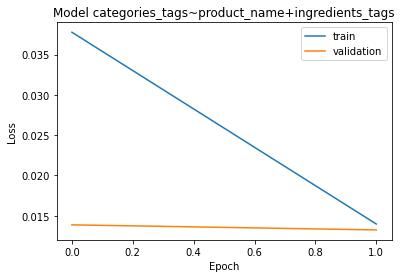

In [14]:
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['loss'])
plt.plot(log_data['epoch'],log_data['val_loss'])
plt.title(f"Model {labels}~{'+'.join(inputs.keys())}")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

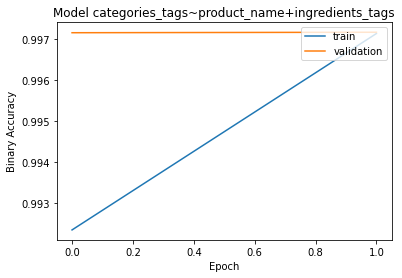

In [15]:
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['binary_accuracy'])
plt.plot(log_data['epoch'],log_data['val_binary_accuracy'])
plt.title(f"Model {labels}~{'+'.join(inputs.keys())}")
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

# Test model

In [8]:
model = tf.keras.models.load_model(OUTPUT_DIR / 'base/saved_model')

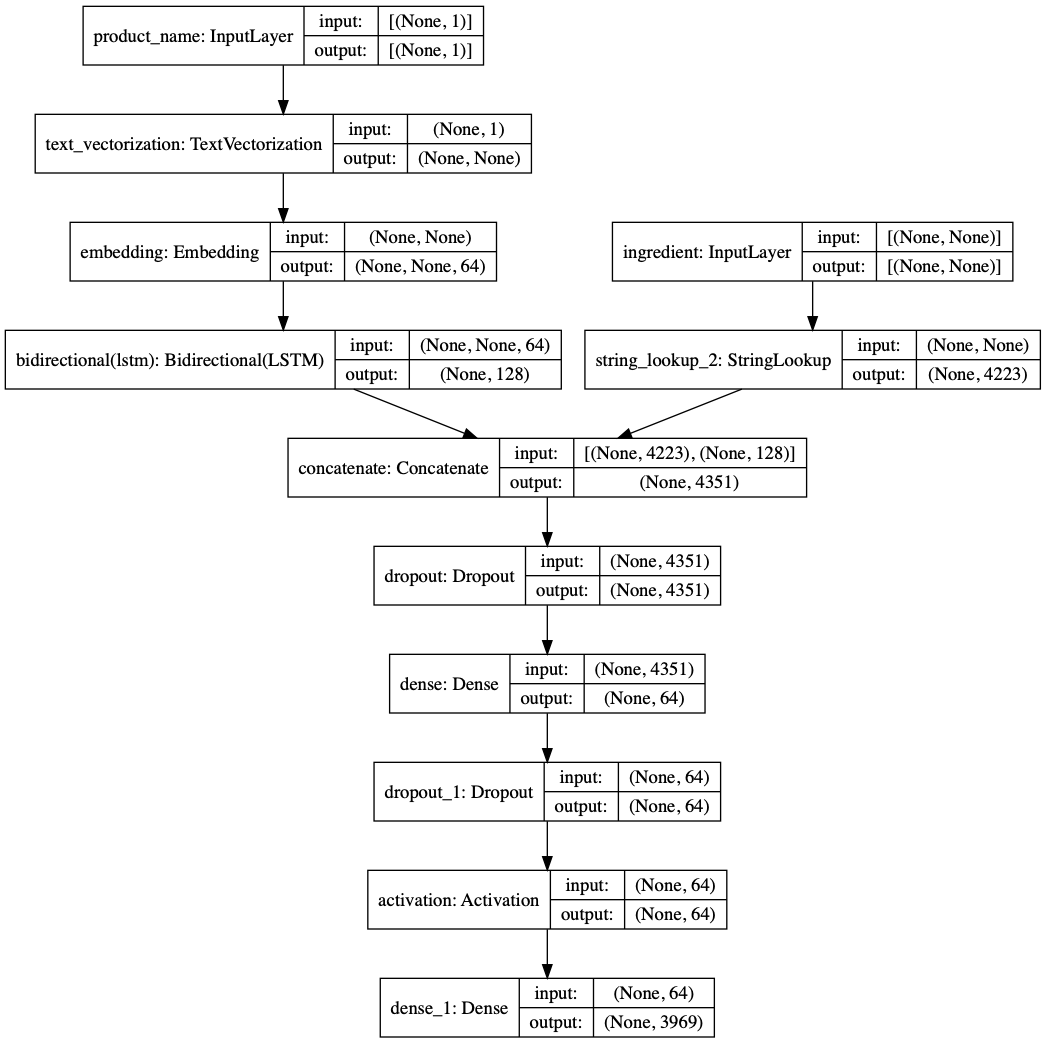

In [10]:
from tf.keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
# create train, validation, test datasets
category_vocab = keras_preprocess.category_vocab
batch_size = config.train_config.batch_size

# Train & validation Dataset => investigate on characteristics of the source
valdata = create_tf_dataset("val", category_vocab, batch_size)
testdata = create_tf_dataset("test", category_vocab, batch_size)

In [12]:
# categories count
len(category_vocab)

3969

## Predict

In [13]:
%%time
y_pred_val = model.predict(valdata)

CPU times: user 1min 33s, sys: 19.8 s, total: 1min 52s
Wall time: 1min 19s


In [14]:
%%time
y_pred_test=model.predict(testdata)

CPU times: user 1min 33s, sys: 17.2 s, total: 1min 50s
Wall time: 1min 19s


In [15]:
y_pred_val.shape, y_pred_test.shape

((87433, 3969), (87433, 3969))

In [16]:
y_pred_val

array([[1.2839634e-05, 2.3829339e-10, 1.6613468e-09, ..., 1.5564917e-11,
        3.6129602e-10, 2.1100532e-12],
       [1.0495579e-01, 2.0508166e-09, 2.3943665e-09, ..., 1.3911613e-08,
        1.0217517e-08, 3.8321792e-07],
       [1.9471225e-05, 6.9090309e-14, 3.4578873e-15, ..., 1.7461139e-10,
        1.5341870e-09, 3.1657670e-11],
       ...,
       [3.8076937e-03, 1.6157297e-06, 6.6229441e-06, ..., 1.5495658e-06,
        8.5407564e-06, 3.0552114e-06],
       [1.3194382e-03, 1.6692168e-10, 3.1451508e-09, ..., 4.1883496e-14,
        4.0008695e-17, 5.4479357e-14],
       [1.3995171e-04, 4.6972501e-09, 6.7628605e-07, ..., 2.1551737e-16,
        4.0634079e-10, 5.0259212e-15]], dtype=float32)

## Translate predictions

In [17]:
import numpy as np

data=y_pred_val
NUMBER_OF_CATEGORIES = 4

values=np.partition(data,-NUMBER_OF_CATEGORIES) #top n probability values for each row
indices=np.argpartition(data,-NUMBER_OF_CATEGORIES) #top n probability values indices for each row

In [18]:
val=values[:,-NUMBER_OF_CATEGORIES:] # filter n first values for each row
ind=indices[:,-NUMBER_OF_CATEGORIES:] # filter n first values indices for each row

In [19]:
dfPredictions=(pd.DataFrame(ind).applymap(lambda x:category_vocab[x])+": "+pd.DataFrame(np.round(val*100,2)).astype(str)+" %").reset_index()

In [20]:
# make dictionary from validation dataframe to get code ande product_name
dict_val=val_ds[['code','product_name']].to_dict()

In [21]:
dfPredictions['product_name']=dfPredictions['index'].apply(lambda x:dict_val['product_name'][x])
dfPredictions['code']=dfPredictions['index'].apply(lambda x:dict_val['code'][x])
dfPredictions=dfPredictions.drop(columns=["index"])

In [22]:
dfPredictions

,0,1,2,3,product_name,code
0,en:groceries: 96.52 %,en:salts: 98.63 %,en:fleurs-de-sel: 97.92 %,en:unrefined-salts: 97.0 %,Fleur de sel,3183280018259
1,en:cereals-and-potatoes: 65.28 %,en:breakfast-cereals: 71.68 %,en:plant-based-foods: 85.16 %,en:plant-based-foods-and-beverages: 85.63 %,coco pops,8690504270591
2,en:plant-based-foods-and-beverages: 74.35 %,en:plant-based-beverages: 75.87 %,en:hot-beverages: 87.98 %,en:beverages: 97.96 %,"Thé épicé Dreaming camomille, lavande & valériane",8719179003652
3,en:plant-milks: 78.42 %,en:milk-substitute: 80.89 %,en:soy-milks: 86.2 %,en:legume-milks: 86.33 %,Soja Vanille Drink,4316268502504
4,en:confectioneries: 59.83 %,en:snacks: 94.23 %,en:sweet-snacks: 94.86 %,en:nougats: 97.1 %,Nougat au miel de Bretagne,3770011407224
...,...,...,...,...,...,...
87428,en:fermented-milk-products: 95.78 %,en:yogurts: 96.79 %,en:dairies: 98.91 %,en:fermented-foods: 97.39 %,Milk chocolate,0072431253607
87429,en:poultries: 91.34 %,en:duck-breasts: 95.89 %,en:ducks: 95.94 %,en:meats: 97.83 %,Yaourt framboise,3175241413616
87430,fr:charcuteries-diverses: 11.99 %,en:prepared-meats: 78.72 %,en:meats: 80.52 %,en:cured-sausages: 29.25 %,Magret de canard,2685323047758
87431,en:cheeses: 99.26 %,en:fermented-milk-products: 99.66 %,en:fermented-foods: 99.69 %,en:dairies: 99.88 %,La fine douce et équilibrée,3700133913709
